# Reproducing Fitness Curves

Authors of the studied article also claim that the proposed TS-DE approach outperforms DE in average fitness optimization and is also less sensitive to mutation rate scheduling.


In [1]:
import sys
import math
from typing import List, Callable

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')

from util.DE.DE import DE
from util.TS_DE.TS_DE import TS_DE
from util.common import zero_population, linear_bayesian_utility_model

**Reproducing right-hand side Figure 6.1.:**

Visualization shows average fitness for different mutation rates in TS-DE, compared to the basic DE approach.

**Parameter setup:**
- *d=10*
- *T=100*
- *M=40* (note that it is unclear what *M* is used in the studied paper)
- *sigma=1*
- *lambda_=1*

**Claims we are testing:**
(i) TS-DE outperforms the basic DE when evaluating average population fitness.
(ii) TS-DE is less sensitive to mutation scheduling.

In [2]:
np.random.seed(seed=0)

# Initial setting for TS-DE and DE
d = 10
M = 40
T = 100
sigma = 1
lambda_ = 1

# Theta star - optimal theta - parametrization of the linear Bayesian utility model for
# which we aim to optimize the protein design.
theta_star = np.random.multivariate_normal(np.zeros(d), np.eye(d))
# Evaluations used to visualize average fitness
evaluations = list(range(T))
# To make the code a bit more slick, we save all results to this variable
# This will later be used for visualization
results = []

In [3]:
# Function returning average fitness for each iteration step (1:T).
def average_fitness_curve(M: int,
                          T: int,
                          f: Callable[[np.ndarray], float],
                          theta: np.ndarray,
                          populations: List[List[np.ndarray]]):
    _avg_fitness_curve = []
    for t in range(T):
        S = populations[t + 1]
        total_fitness = [f(x, theta) for x in S]
        _avg_fitness_curve.append(sum(total_fitness) / M)

    return _avg_fitness_curve

### TS-DE curves

As proposed in the article we try different *mu* values (0.2, 0.5, 0.8). For each we calculate average fitness by iteration step (1:T) for the proposed TS-DE approach.

In [4]:
for mu in [0.2, 0.5, 0.8]:
    populations, _ = TS_DE(d=d,
                           T=T,
                           M=M,
                           theta_star=theta_star,
                           S_0=zero_population(d=d, M=M),
                           mu=mu,
                           sigma=sigma,
                           lambda_=lambda_,
                           f=linear_bayesian_utility_model)
    results.append({
        'label': f"TS-DE (mu={mu})",
        'population': populations
    })

### DE curves

As proposed in the article we try different *mu* values. For each we calculate average fitness by iteration step (1:T) for the proposed DE approach. *mu* values:
- *mu* = 0.1 * 1 / t
- *mu* = 0.5 * 1 / t
- *mu* = 1 / t
- *mu* = 1 / sqrt(t)
- *mu* = 0.5
- *mu* = 0 (random init)


In [5]:
mu_func = {
    '0.1/(t+1)': lambda t: 0.1 / (t + 1),
    '0.5/(t+1)': lambda t: 0.5 / (t + 1),
    '1/t': lambda t: 1 / (t + 1),
    '1/sqrt(t)': lambda t: 1 / math.sqrt(t + 1),
    '0.5': lambda t: 0.5
}
for mu_func_key in mu_func.keys():
    populations = DE(d=d,
                     T=T,
                     sigma=sigma,
                     theta_star=theta_star,
                     S_0=zero_population(d=d, M=M),
                     mu=mu_func[mu_func_key],
                     f=linear_bayesian_utility_model)
    results.append({
        'label': f"DE (mu={mu_func_key})",
        'population': populations
    })

#### Random init (*mu*=0)

In [7]:
from util.common import random_init_population

populations = DE(d=d,
                 T=T,
                 theta_star=theta_star,
                 sigma=sigma,
                 S_0=random_init_population(d=d, M=M),
                 mu=lambda t: 0,
                 f=linear_bayesian_utility_model)
results.append({
    'label': f"DE (mu=0 random_init)",
    'population': populations
})

#### Maximal fitness

Maximal is achieved when all motifs are denoted as favorable (=1).

In [8]:
max_fitness = linear_bayesian_utility_model(
    x=[0 if theta_i < 0 else 1 for theta_i in theta_star],
    theta=theta_star
)

### Visualize results

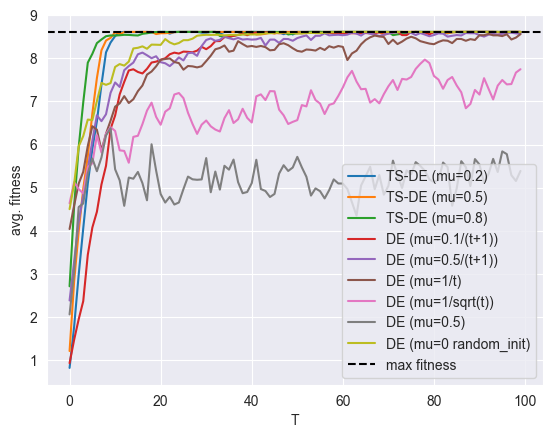

In [11]:
for result in results:
    avg_fitness_curve = average_fitness_curve(M=M,
                                              T=T,
                                              theta=theta_star,
                                              f=linear_bayesian_utility_model,
                                              populations=result['population'])
    plt.plot(evaluations, avg_fitness_curve, label=result['label'])

plt.axhline(y=max_fitness, color='black', label='max fitness', linestyle='--')
plt.legend()
plt.xlabel('T')
plt.ylabel('avg. fitness')
plt.savefig('../plots/fitness_curves.png')
plt.show()